# Burn radius scaling

Three ways of assessing the burn radius are implemented in the code.

The first (`Toon`) follows [Toon et al. 2008](https://pubs.aip.org/physicstoday/article/61/12/37/393240/Environmental-consequences-of-nuclear-warA) and starts from Hiroshima/Nagasaki and scale from there. We scale as $\sqrt{Y}$, and they cite [this](https://www.ncbi.nlm.nih.gov/books/NBK219184/) as the source. What that source actually talks about is the radius at which spontaneous ignition occurs due to radiation heating from the fireball. That's easy to understand: this is just the good old $1/D^2$ scaling law. But this is only valid in a vacuum. In a real atmosphere, the fireball will be surrounded by air, and the radiation will be absorbed by the air (see [The effects of nuclear weapons](https://www.atomicarchive.com/resources/documents/pdfs/effects/effects7.pdf)). Moreover, many fires are actually started by the blast wave (short circuits, gas line ruptures, etc.). So this is not a very good model for the burn radius.

The second (`overpressure`) simply assumes that the burn radius scales like $D^{0.33}$, which is how the overpressure radius scales, see [here](https://forum.effectivealtruism.org/posts/Ysq53coRwgSWHHz2x/nuclear-winter-scepticism) and [here](https://nuclearweaponarchive.org/Nwfaq/Nfaq5.html).

The third and better option (`default`) is the one detailed below, and based on this [work](https://apps.dtic.mil/sti/citations/ADA159280). It accounts for blast-induced ignitions, as well as those induced by thermal radiation. It also considers weather effects, fire spread and countermeasures. This is by far the most sophisticated model I could find. The only limitation is that it provides results only for 50 kt and 1 Mt weapons. But combining this with Hiroshima/Nagasaki values, we can derive a power law, which is what I'm going to do below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")


In [2]:
Y = []
R = []

# Hiroshima and Nagasaki
Y.append(15)
R.append(np.sqrt(13 / np.pi))

# Nagasaki
Y.append(21)
R.append(np.sqrt(6.7 / np.pi))

# 50 kt according to Brode [Fig 26] (I use the mean value and the 50% probability points,
# this neglects what burns further out, but assume complete burn between the 100%
# and 50% radii, so hopefully both cancel out).
Y.append(50)
R.append(2.66*1.609)

# 1 Mt according to Brode [Fig 27]
Y.append(1000)
R.append(6.53*1.609)

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6509/1854780570.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.loglog(Y_fit, np.sqrt(13 / np.pi)*np.power(Y_fit/15, 0.3333333333), ":", label="Blast ($\propto Y^{1/3}$)", lw=1, c="#6c7075", zorder=-30)


[0.74525925 0.38398214]


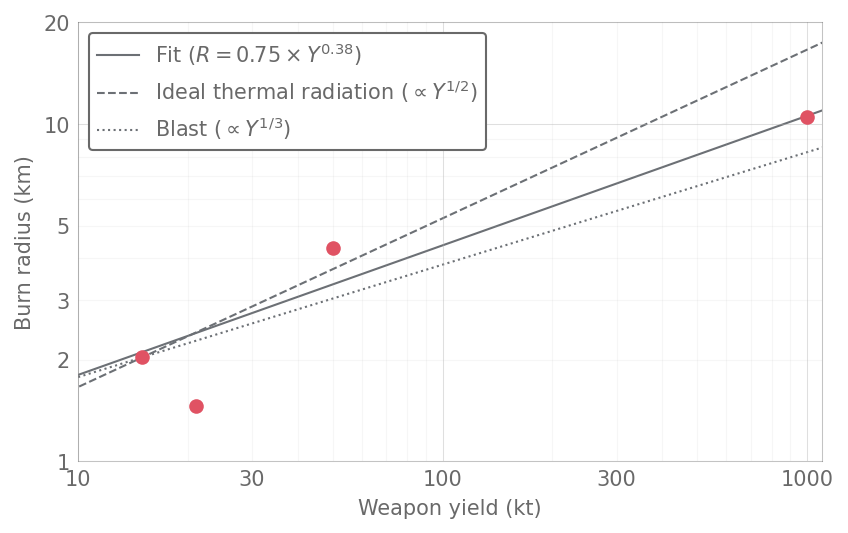

In [16]:
plt.close(1)
plt.figure(1, figsize=(6.4, 3.8))
plt.loglog(Y, R, "o", color="#E05263", ms=7)


# Define power law function
def power_law(x, a, b):
    return a * np.power(x, b)


# Fit power law to data
popt, _ = curve_fit(power_law, Y, R)
print(popt)

# Generate points for the fitted curve
Y_fit = np.logspace(np.log10(1), np.log10(2000), 100)
R_fit = power_law(Y_fit, *popt)

# Plot the fitted curve
plt.loglog(Y_fit, R_fit, "-", label=f"Fit ($R = {popt[0]:.2f}"+r" \times Y^{0.38}$)", lw=1, c="#6c7075", zorder=-30)
plt.loglog(Y_fit, np.sqrt(13 / np.pi)*np.sqrt(Y_fit/15), "--", label=r"Ideal thermal radiation ($\propto Y^{1/2}$)", lw=1, c="#6c7075", zorder=-30)
plt.loglog(Y_fit, np.sqrt(13 / np.pi)*np.power(Y_fit/15, 0.3333333333), ":", label="Blast ($\propto Y^{1/3}$)", lw=1, c="#6c7075", zorder=-30)

plt.grid(True, which="minor", ls="-", alpha=0.1, lw=0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda val, pos: "{:.1f}".format(val) if val < 1 else "{:.0f}".format(val)
    )
)
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda val, pos: "{:.1f}".format(val) if val < 1 else "{:.0f}".format(val)
    )
)

for spine in ax.spines.values():
    spine.set_alpha(0.4)
    spine.set_linewidth(0.5)
    spine.set_color("dimgrey")
    spine.set_visible(True)


# Set minor ticks that we want labeled
ax.xaxis.set_minor_formatter(plt.FuncFormatter(lambda val, pos: "{:.1f}".format(val) if val == 0.3 else "{:.0f}".format(val) if val in [3, 30, 300] else ""))
ax.yaxis.set_minor_formatter(plt.FuncFormatter(lambda val, pos: "{:.1f}".format(val) if val == 0.3 else "{:.0f}".format(val) if val in [2, 3, 5, 20, 30, 300] else ""))
ax.tick_params(axis='both', which='minor', pad=2)

plt.xlim(10, 1100)
plt.ylim(1, 20)
plt.xlabel("Weapon yield (kt)")
plt.ylabel("Burn radius (km)")
plt.legend()
plt.savefig("burn-radius-scaling.png", dpi=300, bbox_inches="tight")